# MissForest Imputation for ThyroidDF

## Libraries

In [ ]:
# %pip install scikit-learn==1.1.2
# %pip install scipy==1.9.1
# %pip install missingpy==0.2.0
# %pip install dataframe_image

In [62]:
import json
import numpy as np
import pandas as pd
import dataframe_image as dfi
from utils.data_split import k_fold_split
from utils.forgetter import forget_random_col_per_sample
from utils.plotter import plot_col_histograms, plot_col_boxplots
from utils.comparison_utils import compare_imputations, compare_imputations2
from utils.category_utils import transform_categorical_columns, inverse_transform_categorical_columns, get_column_indices

In [2]:
import sklearn.neighbors._base
import sys
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base
from missingpy import MissForest

In [3]:
import warnings
warnings.simplefilter('ignore')

## Loading data

In [46]:
qualitative_cols_f = open('data/qualitative_cols.json', 'r')
categorical_cols_f = open('data/categorical_cols.json', 'r')

In [47]:
complete_vals_df = pd.read_csv("data/5-train_df.csv", index_col="Unnamed: 0") 
remove_vals_df = pd.read_csv("data/5-test_df.csv", index_col="Unnamed: 0")
missing_vals_idxs = list(remove_vals_df.index)

sel_qual_cols = json.load(qualitative_cols_f)
sel_cat_cols = json.load(categorical_cols_f)

complete_vals_df = complete_vals_df[sel_cat_cols+sel_qual_cols]
remove_vals_df = remove_vals_df[sel_cat_cols+sel_qual_cols]

real_df = pd.concat([complete_vals_df, remove_vals_df])

In [48]:
transformed_nan_df, label_encoders = transform_categorical_columns(real_df, sel_cat_cols)
transformed_nan_df = transformed_nan_df[sel_cat_cols+sel_qual_cols]
transformed_nan_df

,psych,thyroid_surgery,goitre,tumor,sex,I131_treatment,on_thyroxine,lithium,sick,pregnant,on_antithyroid_meds,T3,FTI,TT4,age,T4U,TSH
7825,0,0,0,0,1,0,0,0,0,0,0,2.3,103.0,90.0,46.0,0.87,1.10
2628,0,0,0,0,0,0,0,0,0,1,0,4.2,110.0,213.0,34.0,1.94,0.05
2935,0,0,0,0,0,0,0,0,0,0,0,2.1,135.0,123.0,71.0,0.91,0.77
996,0,0,0,0,0,0,0,0,0,0,0,0.4,6.6,9.7,41.0,1.46,53.00
3832,0,0,0,0,1,0,0,0,0,0,0,1.5,92.0,101.0,49.0,1.11,2.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6266,1,0,0,0,1,0,0,1,0,0,0,1.8,97.0,91.0,39.0,0.94,1.10
8024,0,0,0,0,1,0,0,1,0,0,0,2.6,107.0,95.0,26.0,0.89,3.10
4111,0,0,0,0,0,0,0,0,0,0,0,2.3,67.0,73.0,24.0,1.09,1.40
2694,0,0,0,0,1,0,0,0,0,0,0,1.9,100.0,87.0,70.0,0.87,0.50


In [49]:
transformed_df = transformed_nan_df.dropna()
transformed_df.shape

(5786, 17)

In [50]:
train_df = complete_vals_df.copy()
test_df = remove_vals_df.copy()

## Train & Test split

In [ ]:
#k = 5

In [ ]:
#print(f"train: {transformed_df.shape[0] / k * (k-1)}\ntest: {transformed_df.shape[0] / k}")

In [ ]:
#train_df, test_df = k_fold_split(transformed_df, k)

## Select missing values

In [51]:
keys = transformed_df.columns
values =  [1] * len(keys)
weight_map = dict(map(lambda i,j : (i,j), keys, values))

In [52]:
weight_map

{'psych': 1,
 'thyroid_surgery': 1,
 'goitre': 1,
 'tumor': 1,
 'sex': 1,
 'I131_treatment': 1,
 'on_thyroxine': 1,
 'lithium': 1,
 'sick': 1,
 'pregnant': 1,
 'on_antithyroid_meds': 1,
 'T3': 1,
 'FTI': 1,
 'TT4': 1,
 'age': 1,
 'T4U': 1,
 'TSH': 1}

In [53]:
seed = 42
random_generator = np.random.default_rng(seed)

In [54]:
train_missing_vals_df, train_missing_col_map, train_missing_vals_idxs = forget_random_col_per_sample(train_df, weight_map, random_generator)
test_missing_vals_df, test_missing_col_map, test_missing_vals_idxs = forget_random_col_per_sample(test_df, weight_map, random_generator)

## MissForest Imputation

In [55]:
imputer = MissForest(missing_values=np.NaN, n_estimators=100, max_iter=20)
imputer = imputer.fit(train_df.to_numpy(), cat_vars=get_column_indices(train_df, sel_cat_cols))

### Results on training set

In [ ]:
X_train = train_missing_vals_df.to_numpy()
X_train_imputed = imputer.transform(X_train)

In [ ]:
imputed_train_df = pd.DataFrame(X_train_imputed, columns=train_missing_vals_df.columns, index=train_missing_vals_df.index)
imputed_train_data_df = inverse_transform_categorical_columns(imputed_train_df.copy(), label_encoders)
imputed_train_data_df

In [ ]:
train_results = compare_imputations2(train_df, imputed_train_df, train_missing_col_map)
train_results

In [ ]:
train_results = compare_imputations(train_df, imputed_train_df)
train_results

In [ ]:
plot_col_histograms(train_df, imputed_train_df, "MissForest")

In [ ]:
# plot_col_boxplots(train_df[sel_qual_cols+['target']], imputed_train_df[sel_qual_cols+['target']], "MissForest")
plot_col_boxplots(train_df[sel_qual_cols], imputed_train_df[sel_qual_cols], "MissForest")

In [ ]:
imputed_means = np.concatenate([imputer.statistics_['col_modes'].flatten(), imputer.statistics_['col_means']])
imputed_means_df = pd.DataFrame([imputed_means], columns=sel_cat_cols+sel_qual_cols)
imputed_means_df = inverse_transform_categorical_columns(imputed_means_df, label_encoders)
imputed_means_df

### Results on test set (cross-validation)

In [59]:
X_test = test_missing_vals_df.to_numpy()
X_test_imputed = imputer.transform(X_test)

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4


In [60]:
imputed_test_df = pd.DataFrame(X_test_imputed, columns=test_missing_vals_df.columns)
imputed_test_data_df = inverse_transform_categorical_columns(imputed_test_df.copy(), label_encoders)
imputed_test_data_df

,psych,thyroid_surgery,goitre,tumor,sex,I131_treatment,on_thyroxine,lithium,sick,pregnant,on_antithyroid_meds,T3,FTI,TT4,age,T4U,TSH
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,153.00,130.0,76.00,0.85,6.2000
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.8,59.00,81.0,57.00,1.38,1.1000
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,126.00,79.0,86.00,0.62,0.0500
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.3,72.00,68.0,37.00,0.94,2.6000
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,129.00,152.0,63.00,1.18,1.8000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1152,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.8,97.00,91.0,39.00,0.94,3.5041
1153,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.6,107.00,95.0,26.00,0.89,3.1000
1154,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.3,67.00,73.0,45.91,1.09,1.4000
1155,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.9,100.00,87.0,70.00,0.87,0.5000


In [63]:
test_results = compare_imputations2(test_df, imputed_test_df, test_missing_col_map)
test_results_styled = test_results.style.background_gradient()
test_results_styled

,Column,MSE,RMSE,MAE
0,sex,0.363636,0.603023,0.363636
1,lithium,0.012048,0.109764,0.012048
2,I131_treatment,0.024691,0.157135,0.024691
3,T3,0.213877,0.462468,0.363888
4,psych,0.029412,0.171499,0.029412
5,goitre,0.012500,0.111803,0.012500
6,tumor,0.000000,0.000000,0.000000
7,sick,0.018868,0.137361,0.018868
8,TSH,195.102376,13.967905,4.851119
9,T4U,0.001763,0.041991,0.022611


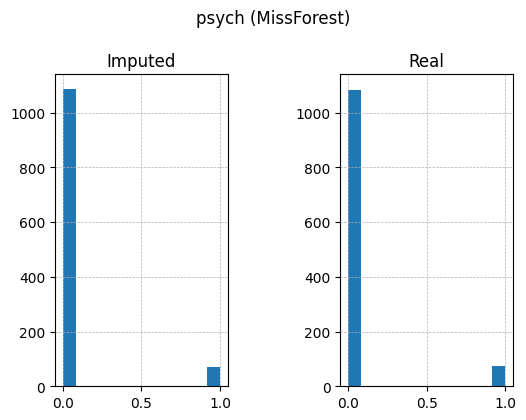

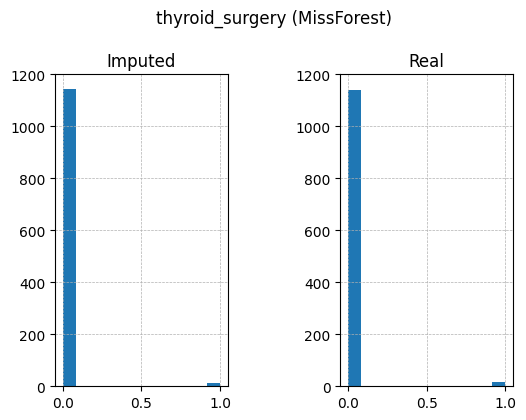

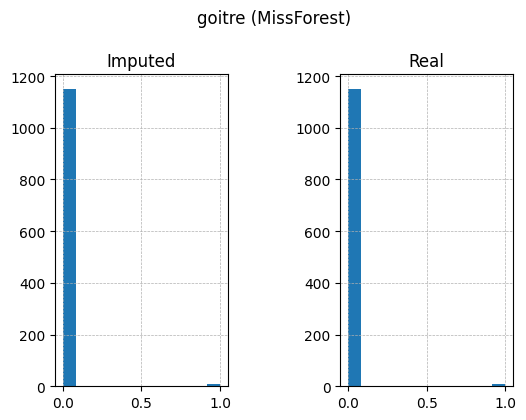

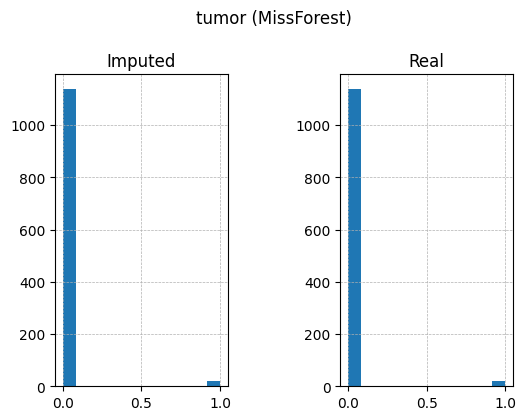

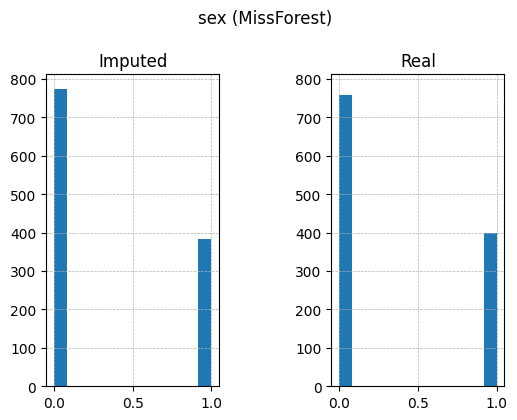

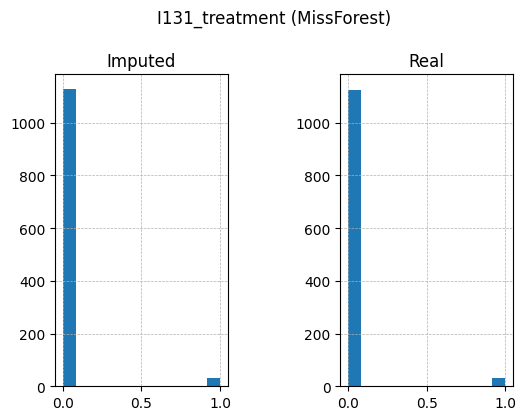

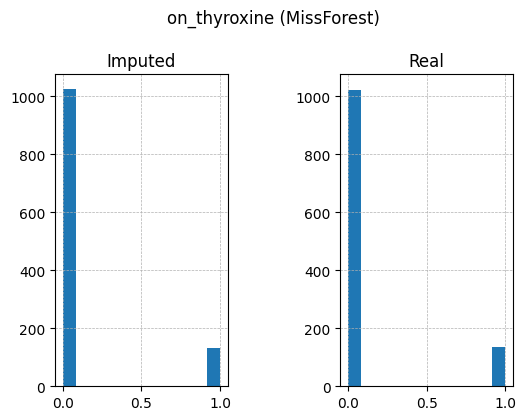

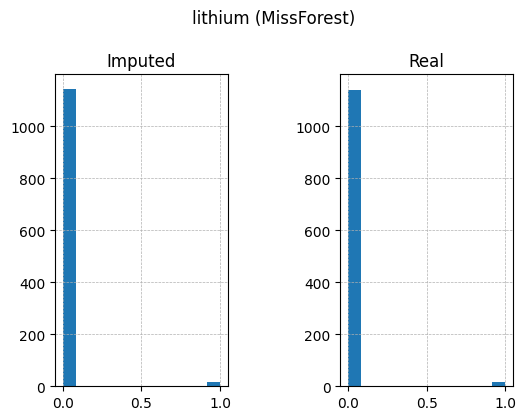

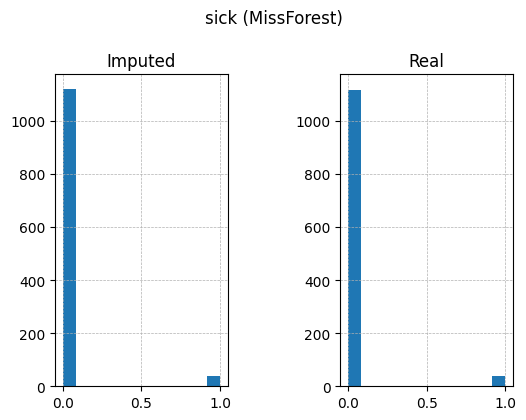

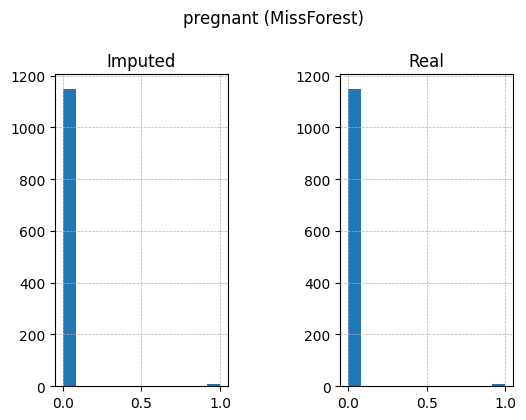

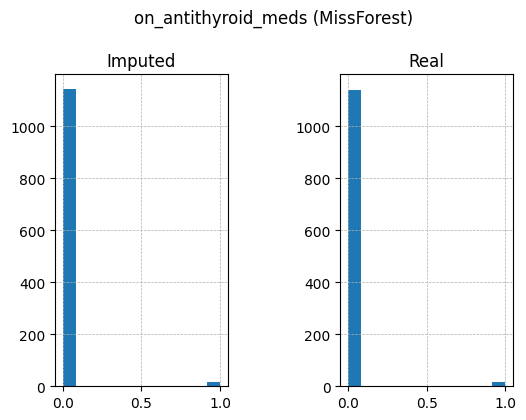

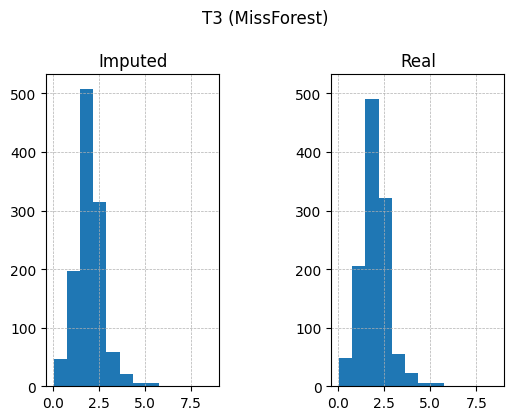

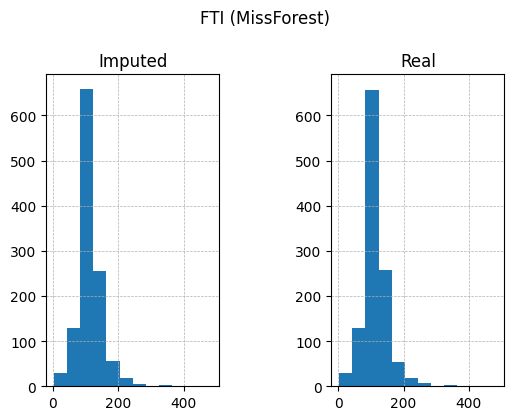

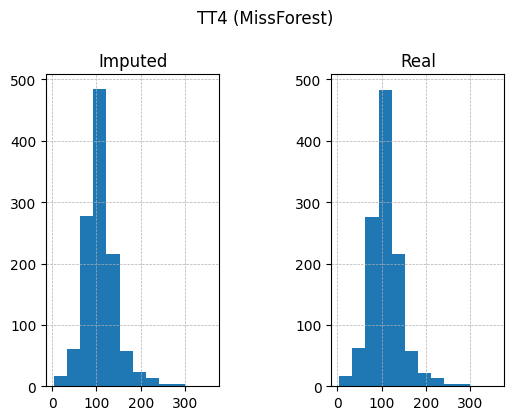

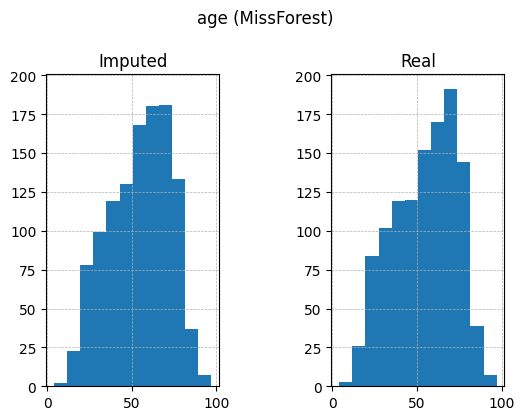

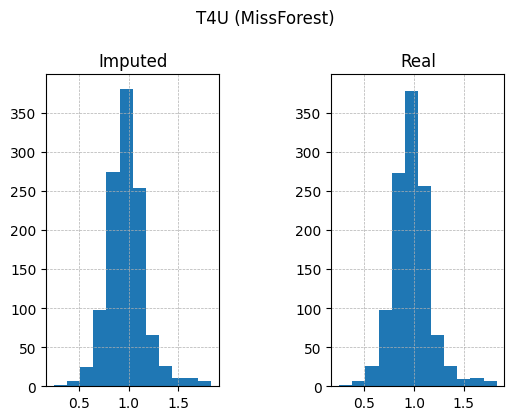

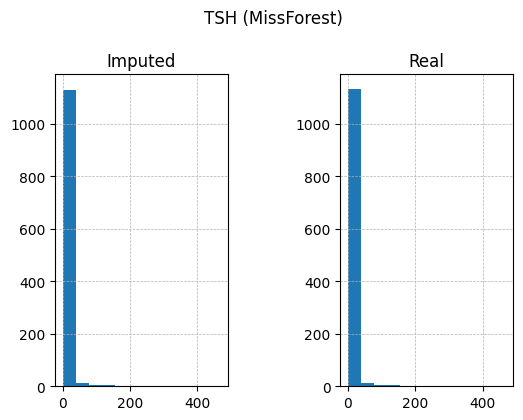

In [64]:
plot_col_histograms(test_df, imputed_test_df, "MissForest")

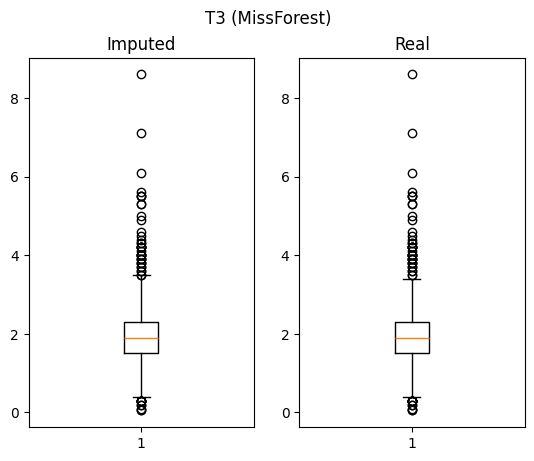

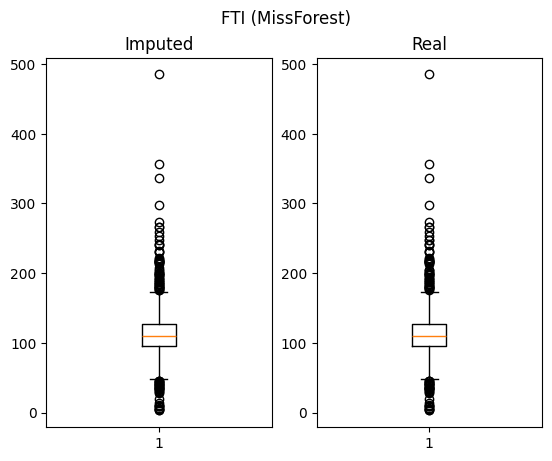

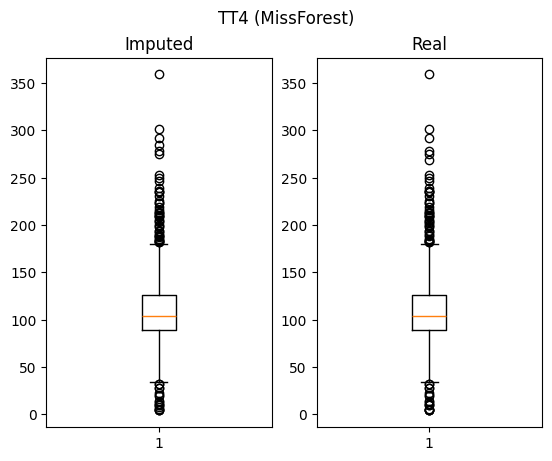

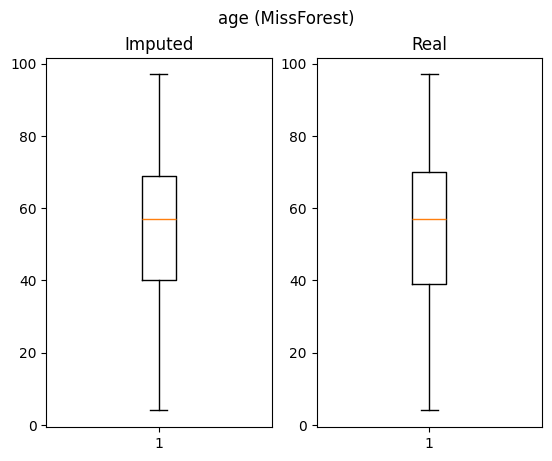

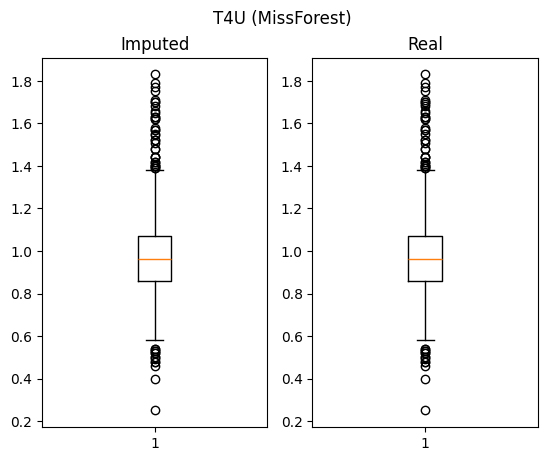

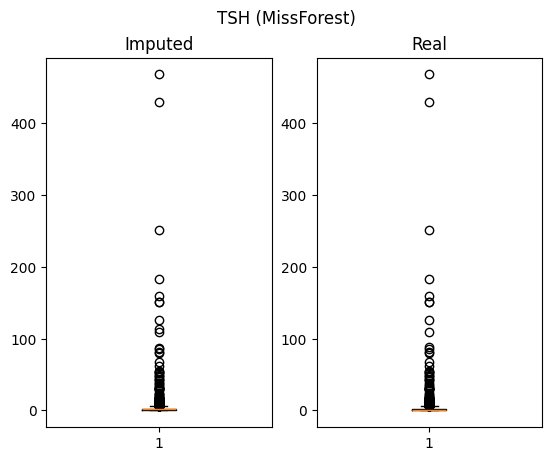

In [65]:
plot_col_boxplots(test_df[sel_qual_cols], imputed_test_df[sel_qual_cols], "MissForest")

## Imputation variant: original data

In [ ]:
all_imputer = MissForest(missing_values=np.NaN, n_estimators=100)
all_imputer = all_imputer.fit(transformed_df.to_numpy(), cat_vars=get_column_indices(transformed_df, sel_cat_cols))

In [ ]:
X = transformed_nan_df.to_numpy()
X_imputed = all_imputer.transform(X)

In [ ]:
imputed_df = pd.DataFrame(X_imputed, columns=transformed_nan_df.columns)
imputed_data_df = inverse_transform_categorical_columns(imputed_df.copy(), label_encoders)
imputed_data_df

Imputation over data with noise:

In [66]:
# import json
# import numpy as np
# import pandas as pd
# from imputation import imputed_sqr_err
# from utils.noise_utils import add_noise_to_column
# from utils.forgetter import forget_random_col_per_sample_2

In [67]:
# seed = 42
# random_state = np.random.RandomState(seed)
# random_generator = np.random.default_rng(seed)

In [68]:
# qualitative_cols_f = open('data/qualitative_cols.json', 'r')
# categorical_cols_f = open('data/categorical_cols.json', 'r')

In [69]:
# complete_vals_df = pd.read_csv("data/5-train_df.csv", index_col="Unnamed: 0") 
# remove_vals_df = pd.read_csv("data/5-test_df.csv", index_col="Unnamed: 0") 
# missing_vals_idxs = list(remove_vals_df.index)

In [70]:
# sel_qual_cols = json.load(qualitative_cols_f)
# sel_cat_cols = json.load(categorical_cols_f)

In [71]:
# noise_range = range(0, 10, 2)

In [72]:
# noisy_df_dict = dict()
# noisy_df_dict[0] = complete_vals_df
# for i in noise_range:
#     if i != 0:
#         noisy_vals_df = complete_vals_df.copy()
#         for col in sel_qual_cols:
#             noisy_vals_df[col] = add_noise_to_column(complete_vals_df, col, i / 10)
        
#         noisy_df_dict[i] = noisy_vals_df

In [75]:
# keys = complete_vals_df.columns
# values =  [1] * len(keys)
# weight_map = dict(map(lambda i,j : (i,j), keys, values))

In [76]:
# missing_vals_df = dict()
# missing_col_map = dict()
# missing_vals_idxs = dict()
# picked_cols = dict()

# real_df = dict()
# curr_df = dict()

# for i in noise_range:
#     missing_vals_df[i], missing_col_map[i], missing_vals_idxs[i], picked_cols[i] = forget_random_col_per_sample_2(remove_vals_df, weight_map, random_generator)

#     real_df[i] = pd.concat([noisy_df_dict[i], remove_vals_df])
#     curr_df[i] = pd.concat([noisy_df_dict[i], missing_vals_df[i]])

In [77]:
# def impute_missf(labeled_df: pd.DataFrame, random_missing_df: pd.DateOffset):
#     imputer = MissForest(missing_values=np.NaN, n_estimators=100)
#     imputer = imputer.fit(labeled_df.to_numpy(), cat_vars=get_column_indices(labeled_df, sel_cat_cols))
#     X = random_missing_df.to_numpy()
#     X_imputed = imputer.transform(X)
#     imputed_df = pd.DataFrame(X_imputed, columns=random_missing_df.columns, index=random_missing_df.index)
#     #imputed_data_df = inverse_transform_categorical_columns(imputed_df.copy(), label_encoders)
#     return imputed_df

In [ ]:
# missf_imputed_df = dict()
# for i in noise_range:
#     missf_imputed_df[i] = impute_missf(real_df[i], curr_df[i])

In [100]:
# missf_sqr_err_dict = dict()
# for i in noise_range:
#     missf_sqr_err_dict[i] = compare_imputations2(real_df[i], missf_imputed_df[i], missing_col_map[i])

In [101]:
# real_cols = [col + " (real)" for col in sel_qual_cols]
# imputed_cols = [col + " (imputed)" for col in sel_qual_cols]

In [ ]:
# import matplotlib.pyplot as plt

# for col in real_df[0].columns:
#     if col not in sel_cat_cols:
#         X = [k for (k) in missf_sqr_err_dict.keys()]
#         Y = [v.loc[missf_sqr_err_dict[0]['Column'] == col]['MSE'] for (_, v) in missf_sqr_err_dict.items()]

#         plt.plot(X, Y, label=col, marker="o")
#         plt.xlabel("Noise scale")
#         plt.ylabel("MSE")
#         plt.title("Miss Forest")

# plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
# plt.show()

## Conf Matrix

In [123]:
cfs_mat_cols = ["T3", "TT4", "TSH"]
expected_dict = dict()
predicted_dict = dict()

In [124]:
def map_t3(val):
    if val < 1.2:
        return "0-1.2"
    elif val >= 1.2 and val <= 3.1:
        return "1.2-3.1"
    return "3.1+" 

In [125]:
def map_tt4(val):
    if val < 58:
        return "0-58"
    elif val >= 58 and val <= 154:
        return "58-154"
    return "154+" 

In [126]:
def map_tsh(val):
    if val < 0.4:
        return "0-0.4"
    elif val >= 0.4 and val <= 5:
        return "0.4-5"
    return "5+" 

In [127]:
mapper = {
    "T3": map_t3,
    "TT4": map_tt4,
    "TSH": map_tsh
}

In [128]:
label_map = {
    "T3": ["0-1.2", "1.2-3.1", "3.1+"],
    "TT4": ["0-58", "58-154", "154+"],
    "TSH": ["0-0.4", "0.4-5", "5+"]
}

In [140]:
for col in cfs_mat_cols:
    predicted_dict[col] = dict()
    expected_dict[col] = dict()

In [143]:
def get_miss_vals_map(df_imputed, index_column_dict):
    df_imputed = df_imputed.reset_index(drop=True)
    missing_vals_idxs_dict = dict(map(lambda i,j : (i,j), index_column_dict.keys(), df_imputed.index))
    return missing_vals_idxs_dict

In [152]:
missing_vals_idxs_dict = get_miss_vals_map(imputed_test_df, test_missing_col_map)

In [150]:
for idx in missing_vals_idxs_dict.keys():
    col = test_missing_col_map[idx]
    if col in cfs_mat_cols:
        predicted_dict[col][idx] = mapper[col](imputed_test_df.iloc[missing_vals_idxs_dict[idx]][col])
        expected_dict[col][idx] = mapper[col](test_df.iloc[missing_vals_idxs_dict[idx]][col])

In [151]:
from confusion_matrix import calculate_relative_confusion_matrix, plot_confusion_matrix

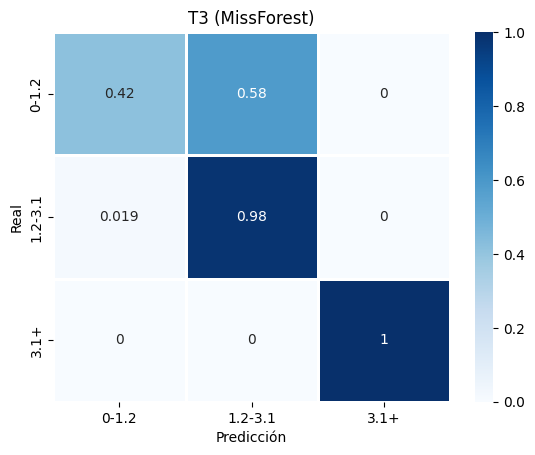

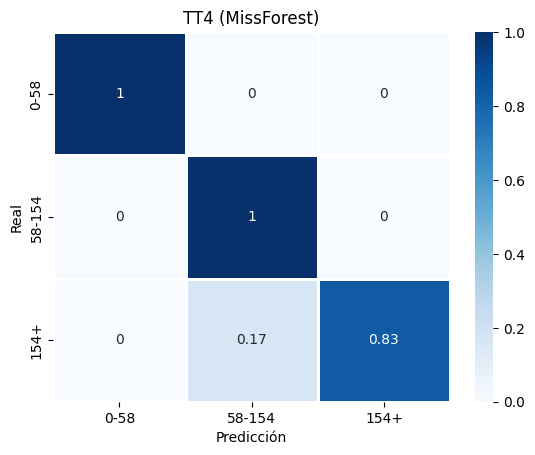

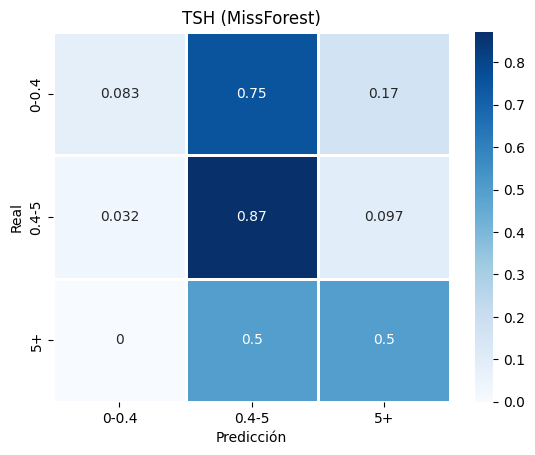

In [155]:
cfs_mats = dict()
for col in cfs_mat_cols:
    cfs_mats[col] = calculate_relative_confusion_matrix(np.array(label_map[col]), predicted_dict[col], expected_dict[col])
    plot_confusion_matrix(cfs_mats[col], col + " (MissForest)", format=".2g")